In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency, chi2 
from scipy.stats import kstest
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

#### Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли 
ользователи
ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
ab_products – подробная информация о продуктах, их название и стоимость

In [2]:
from download import download_yd
ab_users=download_yd('https://disk.yandex.ru/d/4qY27tJ23G_B1g', ',')
ab_orders =download_yd('https://disk.yandex.ru/d/prdO8FDQx7lzCg', ',')
ab_products = download_yd('https://disk.yandex.ru/d/atwrlmB_wu-fHA', ',')

In [3]:
ab_users

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [4]:
ab_orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [5]:
ab_products

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


Для начала посмотрим на количество пропущенных значений в датафреймах и посчитаем число уникальных значений каждого столбца.

In [6]:
ab_users.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [7]:
ab_products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [8]:
ab_orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [9]:
ab_orders.nunique()

order_id         4123
creation_time    4098
product_ids      3877
dtype: int64

In [10]:
ab_users.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [11]:
ab_products.nunique()

product_id    87
name          87
price         63
dtype: int64

В данном случае, чтобы понять, стоит ли включать новую систему, предлагаю использовать следующие метрики:
- средний чек заказов для каждого покупателя
- конверсия отмененных заказов к общему числу заказов всех пользователей
- выручка в разных версиях приложений.


Для начала посмотрим, сколько пользователей в группе 0 и группе 1.

In [12]:
number_of_users_sistem = ab_users.query("group==1").user_id.nunique()
number_of_users_not_sistem = ab_users.query("group==0").user_id.nunique()
print(f'''Количество пользователей в группе без системы рекомендации товаров равно {number_of_users_sistem}, без системы рекомендации товаров равно {number_of_users_not_sistem}.''')

Количество пользователей в группе без системы рекомендации товаров равно 502, без системы рекомендации товаров равно 515.


In [13]:
# Соединим два датафрейма по id заказа
users_orders = ab_users.merge(ab_orders,on='order_id')

In [14]:
users_orders.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


Теперь посмотрим сколько дней длился эксперимент для обоих групп. оно должно быть одинаковым.

In [15]:
users_orders[['time', 'date', 'creation_time']] = users_orders[['time', 'date', 'creation_time']].apply(pd.to_datetime)
users_sistem = users_orders.query("group==1")
users__not_sistem = users_orders.query("group==0")
timedelta_sistem = pd.Timedelta(max(users_sistem['date']) - min(users_sistem['date'])).days
timedelta_not_sistem = pd.Timedelta(max(users__not_sistem['date']) - min(users__not_sistem['date'])).days
print(f'''Длительность эксперимента для приложения без системы рекомендаций - {timedelta_not_sistem} дней, с системой рекомендаций - {timedelta_sistem} дней.''')

Длительность эксперимента для приложения без системы рекомендаций - 13 дней, с системой рекомендаций - 13 дней.


In [16]:
activity_sistem = len(users_orders.query("group==1").order_id)
activity_not_sistem = len(users_orders.query("group==0").order_id)
print(f'''Число заказов с системой поддержки - {activity_sistem}, без системы поддержки - {activity_not_sistem}.''')

Число заказов с системой поддержки - 2646, без системы поддержки - 1691.


C:\Users\mirza\AppData\Local\Temp\ipykernel_51812\808985687.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summa, x='group', y='order_id', palette='Set1')


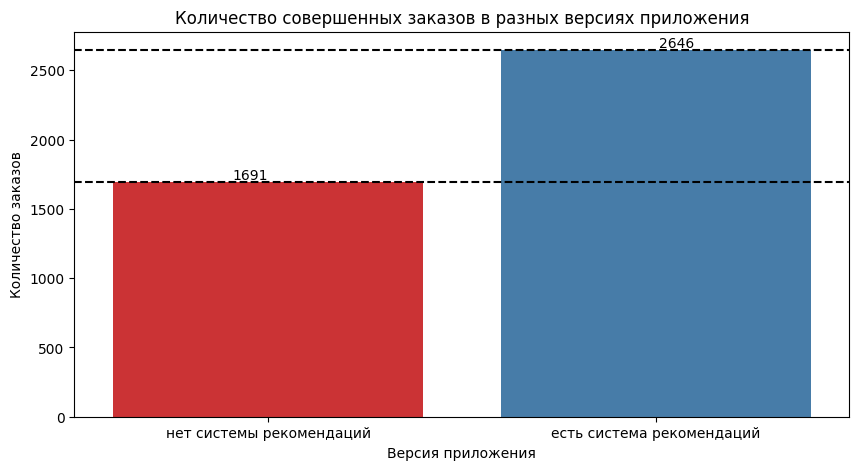

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

summa = users_orders.groupby('group', as_index=False).order_id.count()
summa['group'] = summa['group'].apply(lambda x: 'есть система рекомендаций' if x == 1 else 'нет системы рекомендаций')

plt.figure(figsize=(10, 5))
sns.barplot(data=summa, x='group', y='order_id', palette='Set1')
plt.title('Количество совершенных заказов в разных версиях приложения')
plt.xlabel('Версия приложения')
plt.ylabel('Количество заказов')

# Вычисляем максимальное и минимальное значение
max_value_with_system = summa['order_id'].max()
max_value_not_system = summa['order_id'].min()

# Добавляем линии с максимальным и минимальным значениями
plt.axhline(y=max_value_with_system, color='black', linestyle='--')
plt.axhline(y=max_value_not_system, color='black', linestyle='--')

# Подписываем максимальное и минимальное значения
plt.text(1.1, max_value_with_system, max_value_with_system, ha='right', va='bottom', color='black')
plt.text(0, max_value_not_system, max_value_not_system, ha='right', va='bottom', color='black')
#plt.savefig('Количество совершенных заказов в разных версиях приложения.jpeg')
plt.show()


На данный момент мы имеем примерно одинаковое число пользователей, привлеченных для эксперимента, и одинаковое количество дней. Однако, если посмотреть на активность пользователей, которую можно оценить общим количество заказов, неважно отмененных или нет, то у приложения с системой рекомендаций активность увеличилась, что может говорить о том, что пользователям нравится использовать новую версию приложения. 

Теперь найдем стоимость каждого заказа

In [28]:
users_orders['product_ids'] = users_orders['product_ids'].apply(lambda x: [int(i) for i in x.strip('{}').split(',')])

In [29]:
def calculate_total_price(product_ids):
    total_price = sum(ab_products[ab_products['product_id'].isin(product_ids)]['price'])
    return total_price

In [30]:
users_orders['total_price'] = users_orders['product_ids'].apply(calculate_total_price)

In [32]:
users_orders

,user_id,order_id,action,time,date,group,creation_time,product_ids,total_price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",310.2
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]",85.0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]",228.0
...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,2022-09-08 23:13:03,"[84, 8, 24]",241.2
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]",518.5
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,2022-09-08 23:22:27,"[60, 41, 46]",185.9
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,"[9, 62, 77]",501.9


Проверим пересекаются ли у нас пользователи в разных версиях приложения

In [33]:
# Выбор пользователей из группы 1
users_group_1 = set(users_orders.query("group == 1")['user_id'])
# Выбор пользователей из группы 0
users_group_0 = set(users_orders.query("group == 0")['user_id'])
# Нахождение пересечения пользователей из обеих групп
users_group_1.intersection(users_group_0)

set()

Как видно наши пользователи не пересекаются

Посчитаем средний чек на каждого покупателя для разных версий приложения, только для совершенных заказов.

In [34]:
# Средний чек для пользователей со старой версией приложения.
average_check_not_sistem = users_orders.query("group==0 and action=='create_order'").groupby('user_id',as_index=False)\
                                        .agg({'total_price':'mean'})\
                                        .rename(columns={'total_price':'average_check'})
# Средний чек для пользователей c версией приложения, использующей систему рекомендаций.
average_check_with_sistem = users_orders.query("group==1 and action=='create_order'").groupby('user_id',as_index=False)\
                                        .agg({'total_price':'mean'})\
                                        .rename(columns={'total_price':'average_check'})
average_check_not_sistem_total = np.round(average_check_not_sistem.average_check.mean(),2)
average_check_with_sistem_total = np.round(average_check_with_sistem.average_check.mean(),2)
print(f'''Средний чек в новой версии приложения - {average_check_with_sistem_total}, в старой версии - {average_check_not_sistem_total}. В старой версии он был больше.''')

Средний чек в новой версии приложения - 365.7, в старой версии - 376.04. В старой версии он был больше.


Теперь предлагаю провести тест, чтобы выяснить действительно ли наши средние чеки статистически значимо различаются. Для начала посмотрим распределены наши данные нормально или нет. Используя гистограмму частот, и QQ-plot.

Text(0, 0.5, 'Частота')

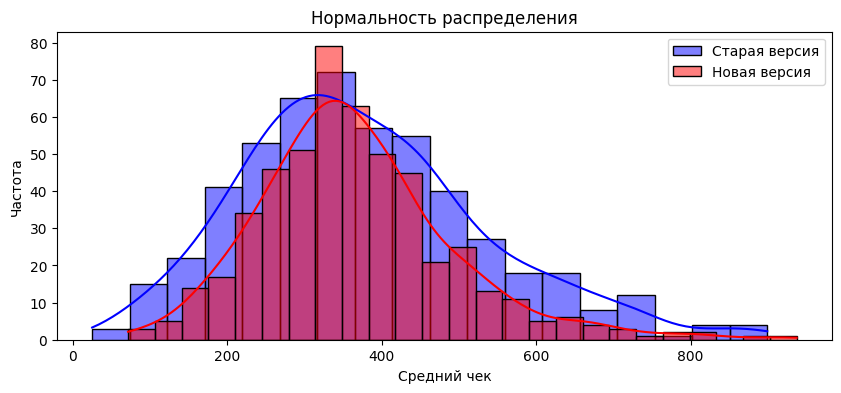

In [35]:
plt.figure(figsize=(10, 4))
sns.histplot(data=average_check_not_sistem, x='average_check', kde=True,color='blue', label='Старая версия')
sns.histplot(data=average_check_with_sistem, x='average_check', kde=True,color='red', label='Новая версия')
plt.legend()
plt.title('Нормальность распределения')
plt.xlabel('Средний чек')
plt.ylabel('Частота')

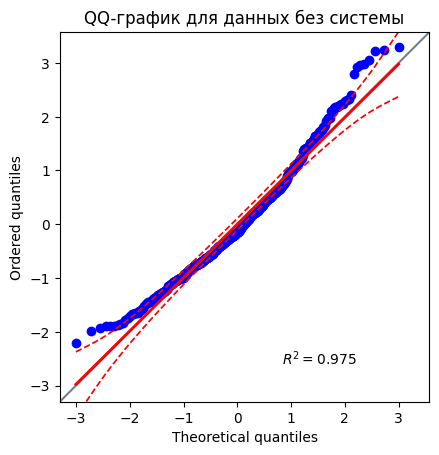

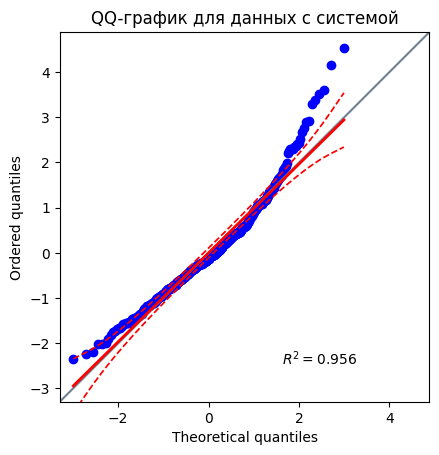

In [36]:
# Создание QQ-графика для данных average_check_not_sistem
import pingouin as pg
pg.qqplot(average_check_not_sistem['average_check'])
plt.title('QQ-график для данных без системы')
plt.show()

# Создание QQ-графика для данных average_check_with_sistem
pg.qqplot(average_check_with_sistem['average_check'])
plt.title('QQ-график для данных с системой')
plt.show()

Построим boxplot и посмотрим на гомогенность дисперсий.

C:\Users\mirza\AppData\Local\Temp\ipykernel_51812\2613835772.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Версия', y='Средний чек', data=data, palette='Set1')


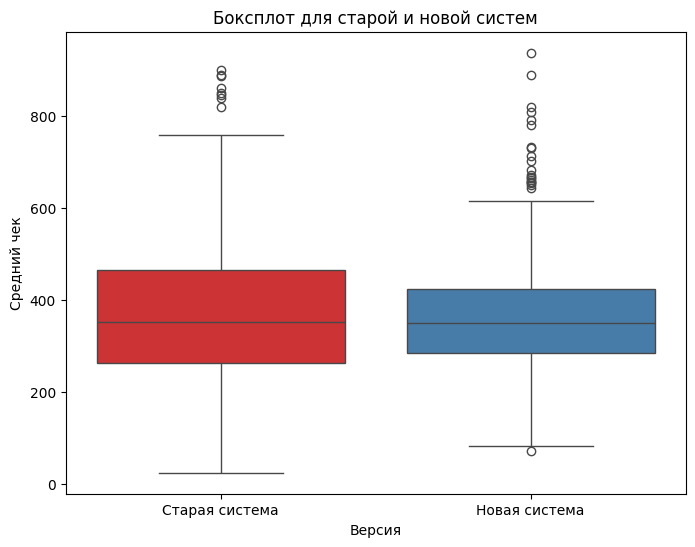

In [37]:
data = pd.DataFrame({
    'Версия': ['Старая система'] * len(average_check_not_sistem['average_check']) + ['Новая система'] * len(average_check_with_sistem['average_check']),
    'Средний чек': list(average_check_not_sistem['average_check']) + list(average_check_with_sistem['average_check'])
})

# Строим boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Версия', y='Средний чек', data=data, palette='Set1')
plt.title('Боксплот для старой и новой систем')
plt.ylabel('Средний чек')
plt.show()

In [38]:
#Проведение теста Левена на гомогенность дисперсий
from scipy.stats import levene
statistic, p_value = levene(average_check_not_sistem['average_check'], average_check_with_sistem['average_check'])
print("Статистика теста Левена:", statistic)
print("p-значение:", p_value)

Статистика теста Левена: 26.72675817394165
p-значение: 2.821812691864364e-07


In [39]:
# Проведение теста Колмогорова-Смирнова на нормальность распределения данных
from scipy.stats import ks_2samp
statistic, p_value = ks_2samp(average_check_not_sistem['average_check'], average_check_with_sistem['average_check'])
# Вывод результатов теста
print("Статистика теста Колмогорова-Смирнова:", statistic)
print("p-значение:", p_value)

Статистика теста Колмогорова-Смирнова: 0.09987622326229065
p-значение: 0.011381168746469935


Как видно выше, наши дисперсии не гомогенны, а также в обоих выборках отсутствует нормальность. Но так как количество значений большое, будем применять t-test.
Нулевая гипотеза - Средние чеки в разных версиях приложений стат.значимо не различаются.
Альтернаятивная гипотеза - Средние чеки в разных версиях приложений стат.значимо различаются.

In [40]:
from scipy.stats import ttest_ind
stat, p_value =ttest_ind(average_check_not_sistem['average_check'],average_check_with_sistem['average_check'])
print(f'Уровень значимости нулевой гипотезы, при использовании T-test, равен {np.round(p_value*100,2)}.')

Уровень значимости нулевой гипотезы, при использовании T-test, равен 25.13.


Исходя из вышепроведенного теста, у нас нет оснований отклонить нулевую гипотезу. На данный момент можно предположить что средние чеки статистически не отличаются.

Теперь будем считать конверсию отмененных заказов к общему числу заказов всех пользователей. 

In [41]:
cancellations_with_sistem=np.round(users_orders.query("action=='cancel_order' and group==1")\
.order_id.count()/users_orders.query("group==1").order_id.count()*100,2)
cancellations_not_sistem=np.round(users_orders.query("action=='cancel_order' and group==0")\
.order_id.count()/users_orders.query("group==0").order_id.count()*100,2)
print(f'''Конверсия отмененных заказов к общему числу заказов всех пользователей, в версии приложения без системы рекомендаций - {cancellations_not_sistem}, 
с системой рекомендаций - {cancellations_with_sistem}. Они равны.''')

Конверсия отмененных заказов к общему числу заказов всех пользователей, в версии приложения без системы рекомендаций - 4.85, 
с системой рекомендаций - 4.99. Они равны.


Посчитаем выручку для старой и для новой версии приложения.

In [42]:
revenue_with_sistem=np.round(users_orders.query("action=='create_order' and group==1").total_price.sum(),2)
revenue_not_sistem=np.round(users_orders.query("action=='create_order' and group==0").total_price.sum(),2)
print(f'''Выручка в версии приложения без системы рекомендаций - {revenue_not_sistem}, с системой рекомендаций - {revenue_with_sistem}.''')

Выручка в версии приложения без системы рекомендаций - 602491.7, с системой рекомендаций - 910009.3.


In [43]:
# Выручка для пользователей со старой версией приложения.
revenue_not_sistem = users_orders.query("group==0 and action=='create_order'").groupby('user_id',as_index=False)\
                                        .agg({'total_price':'sum'})\
                                        .rename(columns={'total_price':'revenue'})
# Выручка для пользователей c версией приложения использующей систему рекомендаций.
revenue_with_sistem = users_orders.query("group==1 and action=='create_order'").groupby('user_id',as_index=False)\
                                        .agg({'total_price':'sum'})\
                                        .rename(columns={'total_price':'revenue'})
revenue_not_sistem_mean = np.round(revenue_not_sistem.revenue.mean(),2)
revenue_with_sistem_mean = np.round(revenue_with_sistem.revenue.mean(),2)
print(f'''Величина средней выручки на каждого пользователя в новой версии приложения - {revenue_with_sistem_mean}, в старой версии - {revenue_not_sistem_mean}. В новой версии выручка стала больше.''')

Величина средней выручки на каждого пользователя в новой версии приложения - 1812.77, в старой версии - 1169.89. В новой версии выручка стала больше.


Однако, если смотреть на выручку, то за 13 дней эксперимента, пользователи, использующие приложение с новой системой рекомендаций, купили товаров на гораздо большую сумму, чем пользователи в приложении без системы рекомендаций. И средний размер выручки на каждого пользователя гораздо выше. Это говорит о том, пользователи стали чаще покупать товары, средний чек не поменялся, количество отмен тоже не изменилось, однако выручка выросла. Это значит, что пользователям нравится пользоваться приложением с системой рекомендаций.
Теперь предлагаю провести тест, чтобы выяснить действительно ли размеры средней выручки статистически значимо различаются. Для начала посмотрим распределены наши данные нормально или нет. Используя гистограмму частот, и QQ-plot.

Text(0, 0.5, 'Частота')

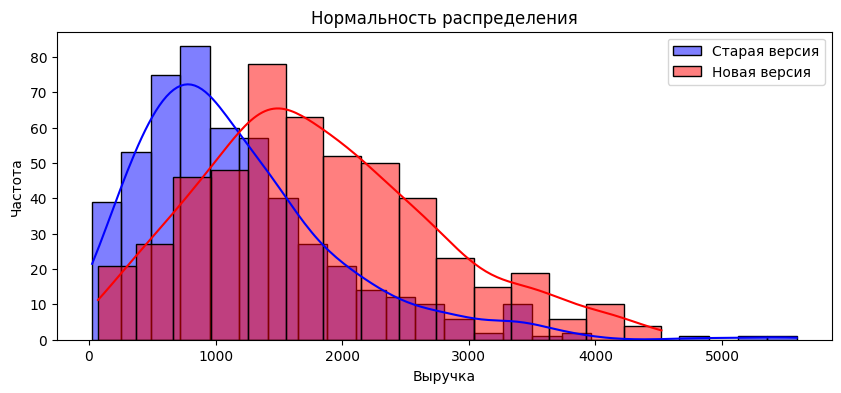

In [44]:
plt.figure(figsize=(10, 4))
sns.histplot(data=revenue_not_sistem, x='revenue', kde=True,color='blue', label='Старая версия')
sns.histplot(data=revenue_with_sistem, x='revenue', kde=True,color='red', label='Новая версия')
plt.legend()
plt.title('Нормальность распределения')
plt.xlabel('Выручка')
plt.ylabel('Частота')

C:\Users\mirza\AppData\Local\Temp\ipykernel_51812\3535571455.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Версия', y='Выручка', data=data, palette='Set1')


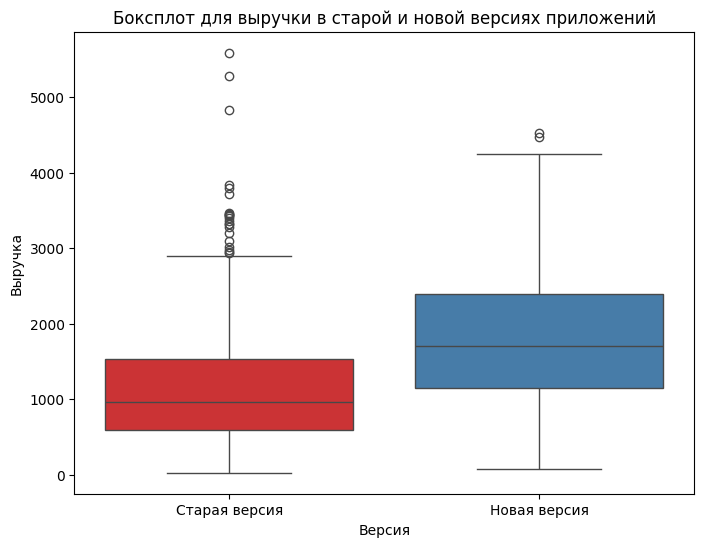

In [45]:
data = pd.DataFrame({
    'Версия': ['Старая версия'] * len(revenue_not_sistem['revenue']) + ['Новая версия'] * len(revenue_with_sistem['revenue']),
    'Выручка': list(revenue_not_sistem['revenue']) + list(revenue_with_sistem['revenue'])
})

# Строим boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Версия', y='Выручка', data=data, palette='Set1')
plt.title('Боксплот для выручки в старой и новой версиях приложений')
plt.ylabel('Выручка')
plt.show()

In [46]:
#Проведение теста Левена на гомогенность дисперсий
from scipy.stats import levene
statistic, p_value = levene(revenue_not_sistem['revenue'], revenue_with_sistem['revenue'])
print("Статистика теста Левена:", statistic)
print("p-значение:", p_value)

Статистика теста Левена: 15.616459100669976
p-значение: 8.294641647085203e-05


In [47]:
# Проведение теста Колмогорова-Смирнова на нормальность распределения данных
from scipy.stats import ks_2samp
statistic, p_value = ks_2samp(revenue_not_sistem['revenue'], revenue_with_sistem['revenue'])
# Вывод результатов теста
print("Статистика теста Колмогорова-Смирнова:", statistic)
print("p-значение:", p_value)

Статистика теста Колмогорова-Смирнова: 0.3519823618148764
p-значение: 1.7143778224879766e-28


Как видно из графиков и тестов, нормальность распределений отсутствует и дисперсии не гомогенны.
Так как у нас большие выборки проведем t-test.

In [48]:
from scipy.stats import ttest_ind
print(ttest_ind(revenue_not_sistem['revenue'],revenue_with_sistem['revenue']), '- t-test')


TtestResult(statistic=-11.732840986654413, pvalue=6.686278305618773e-30, df=1015.0) - t-test


Исходя из теста у нас есть все основания полагать, что наши выборки статистически значимо различаются.

## Вывод
На основании выше изложенного, у нас достаточно оснований, чтобы приложение с умной системой рекомендации товаров было распространено на всех пользователей. С достаточно высокой вероятностью, новое приложение поспособствует увеличению выручки от продажи товаров.